<a href="https://colab.research.google.com/github/Kushagratandon12/Intel_Image-Classification/blob/master/iNTEL_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection From Kaggle

In [ ]:
# !pip install kaggle
# # # from google.colab import files
# # # files.upload()
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d puneet6060/intel-image-classification

#####NOTES ON 
# https://www.notion.so/TensorFlow-2-O-Notes-ff1463fb14f54affa0d4e4390c1152dc

 96% 334M/346M [00:01<00:00, 184MB/s]
100% 346M/346M [00:01<00:00, 183MB/s]


In [ ]:
#UNZIP THE DATA DOWNLOADED FROM KAGGLE 
# import zipfile
# local_zip = '/content/intel-image-classification.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

# Image Pre-Processing


In [ ]:
train_image = '/content/seg_train/seg_train'
test_img = '/content/seg_test/seg_test'

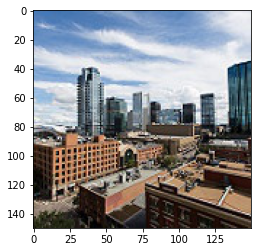

In [ ]:
import matplotlib.pyplot as plt
img1 = plt.imread('/content/seg_train/seg_train/buildings/10006.jpg')
#img2 = plt.imread('/content/seg_train/seg_train/forest/10010.jpg')
plt.imshow(img1)
#plt.imshow(img2)

# Image Data Generator - Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
train_df = keras.preprocessing.image_dataset_from_directory(
    train_image,
    shuffle = True,
    image_size=(160,160), 
)

Found 14034 files belonging to 6 classes.


In [ ]:
#Total Number Of Classes In The System
classes = train_df.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


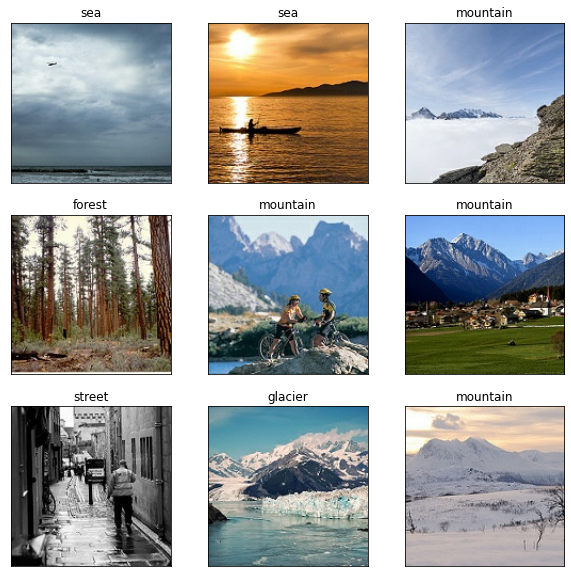

In [71]:
plt.figure(figsize=(10,10))

for images, labels in train_df.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255) 
    plt.title(classes[labels[i]])
    plt.xticks([])
    plt.yticks([])

# IMAGE AGUMENTATION

In [ ]:
TRAINING_DIR = '/content/seg_train/seg_train'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range=0.2,
    zoom_range = 0.2
)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(160, 160))

Found 14034 images belonging to 6 classes.


In [ ]:
VALIDATION_DIR = '/content/seg_test/seg_test'
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )#YOUR CODE HERE
validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(160, 160))

Found 3000 images belonging to 6 classes.


# Creation / Using Of Model

In [ ]:
# # pre_trained_model = tf.keras.applications.ResNet152V2(input_shape = (160,160,3) , include_top = False , weights = 'imagenet' )
# pre_trained_model = tf.keras.applications.ResNet50(input_shape=(160,160,3),include_top=False,weights='imagenet')
# # Make all the layers in the pre-trained model non-trainable
# # Print the model summary
# for layer in pre_trained_model.layers:
#      layer.trainable = False

# # pretrained_model.summary()
        
# #step3        

# pre_trained_model.summary() 

In [ ]:
# last_layer = pre_trained_model.get_layer('conv4_block6_add')
# last_layer = last_layer.output

In [ ]:
# #SELECTING LAST LAYER IN THE MODEL 
# print(last_layer)

In [ ]:
import tensorflow as tf
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
model = Models.Sequential()
model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))
model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Last Layer Was Enabled Using My Developed Model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 50)        4

In [ ]:
history = model.fit(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/5
702/702 [==============================] - 170s 230ms/step - loss: 1.5150 - accuracy: 0.3614 - val_loss: 1.0699 - val_accuracy: 0.5677
Epoch 2/5
702/702 [==============================] - 170s 242ms/step - loss: 1.1266 - accuracy: 0.5461 - val_loss: 0.9746 - val_accuracy: 0.6197
Epoch 3/5
702/702 [==============================] - 171s 243ms/step - loss: 0.9950 - accuracy: 0.6068 - val_loss: 0.8210 - val_accuracy: 0.6907
Epoch 4/5
702/702 [==============================] - 171s 243ms/step - loss: 0.8455 - accuracy: 0.6926 - val_loss: 0.7087 - val_accuracy: 0.7443
Epoch 5/5
702/702 [==============================] - 171s 243ms/step - loss: 0.7535 - accuracy: 0.7401 - val_loss: 0.6100 - val_accuracy: 0.7770


In [18]:
tf.saved_model.save(model,'intel_model')

INFO:tensorflow:Assets written to: intel_model/assets


In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/intel_model') # path to the SavedModel directory
tflite_model = converter.convert()

with open('tflite_model','wb') as file:
  file.write(tflite_model)

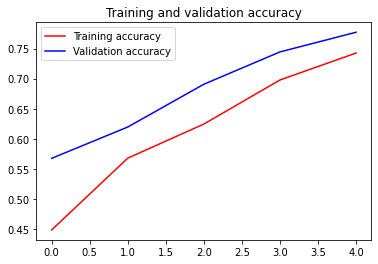

<Figure size 432x288 with 0 Axes>

In [22]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<class 'list'>


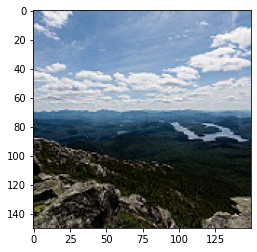

In [57]:
import glob
import random
pred_img = glob.glob('/content/seg_pred/seg_pred/*.jpg')
img_select = random.randint(1,len(pred_img))
print(type(pred_img))
img = plt.imread(pred_img[img_select])
plt.imshow(img)

#Using TENSORFLOW LITE 


In [62]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/tflite_model")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [63]:
img = cv2.resize(img,(150,150))

In [70]:

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.expand_dims(img,0), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
# print(input_data)

interpreter.invoke()
output_details = interpreter.get_output_details()

In [65]:
output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)
print(results)
pred = np.argmax(results)
print(pred)
print(classes[pred])

[0. 0. 0. 1. 0. 0.]
3
mountain
